# Metrics Analysis: Coverage e Mutation Testing

Questo notebook analizza le metriche di **code coverage** e **mutation score** per ogni agente (single_agent, multi_agent_collaborative, multi_agent_competitive).

In [1]:
import sys
import os
from pathlib import Path
from importlib import reload
import pandas as pd

# Aggiungi il path del progetto
PROJECT_ROOT = Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

# Import e reload delle funzioni di evaluation (per caricare le ultime modifiche)
import evaluation.run_coverage as run_coverage_module
import evaluation.run_mutation as run_mutation_module

reload(run_coverage_module)
reload(run_mutation_module)

from evaluation.run_coverage import run_coverage, get_coverage_summary
from evaluation.run_mutation import run_mutation_testing, get_mutation_summary

print(f"Project root: {PROJECT_ROOT}")
print("Moduli ricaricati correttamente!")

Project root: /home/einrich99/Progetti/LLM-Agents-for-Collaborative-Test-Case
Moduli ricaricati correttamente!


## Configurazione Paths

Definiamo i path delle cartelle di input (codice sorgente) e output (test generati).

In [2]:
# Paths configuration
INPUT_CODE_DIR = PROJECT_ROOT / "data" / "input_code"
OUTPUT_TESTS_DIR = PROJECT_ROOT / "data" / "output_tests"


# Mapping tra nome del file test e il modulo sorgente corrispondente
def get_source_module(test_file: Path) -> str:
    """Estrae il nome del modulo sorgente dal nome del file test.
    Ritorna il modulo Python (es. 'data.input_code.library') per pytest-cov.
    """
    # test_library.py -> library
    test_name = test_file.stem  # test_library
    source_name = test_name.replace("test_", "")  # library
    # Ritorna il modulo Python, non il path del file
    return f"data.input_code.{source_name}"


def get_source_file_path(test_file: Path) -> str:
    """Ritorna il path del file sorgente per mutmut."""
    test_name = test_file.stem  # test_library
    source_name = test_name.replace("test_", "") + ".py"  # library.py
    return str(INPUT_CODE_DIR / source_name)


# Lista degli agenti (sottocartelle)
AGENTS = [d.name for d in OUTPUT_TESTS_DIR.iterdir() if d.is_dir()]
print(f"Agenti trovati: {AGENTS}")

Agenti trovati: ['single_agent-llama8b', 'single_agent-oss', 'competitive_agents-scout-maverick-oss', 'collaborative_agents-scout-maverick']


## Funzione di Analisi

Funzione principale che esegue coverage e mutation testing per tutti i test di un agente.

In [3]:
def analyze_agent(agent_name: str, run_mutation: bool = True) -> dict:
    """
    Analizza tutti i test di un agente, eseguendo coverage e mutation testing.

    Args:
        agent_name: Nome della cartella dell'agente (es. 'single_agent')
        run_mutation: Se True, esegue anche mutation testing (più lento)

    Returns:
        Dizionario con i risultati per ogni test file
    """
    agent_dir = OUTPUT_TESTS_DIR / agent_name
    test_files = list(agent_dir.glob("test_*.py"))

    results = []

    for test_file in test_files:
        # Per coverage: usa il modulo Python (es. 'data.input_code.library')
        source_module = get_source_module(test_file)
        # Per mutmut: usa il path del file (es. 'data/input_code/library.py')
        source_file_path = get_source_file_path(test_file)
        # Nome del file sorgente per display
        source_name = test_file.stem.replace("test_", "")

        print(f"\n{'='*60}")
        print(f"Analyzing: {agent_name} / {test_file.name}")
        print(f"Source: {source_name}.py")
        print(f"{'='*60}")

        result = {
            "agent": agent_name,
            "test_file": test_file.name,
            "source_file": f"{source_name}.py",
            "coverage_percent": 0,
            "passed_tests": 0,
            "failed_tests": 0,
            "mutation_score": 0.0,
            "mutants_killed": 0,
            "mutants_survived": 0,
            "coverage_success": False,
            "mutation_success": False,
        }

        # Run Coverage
        print("\n[1/2] Running Coverage...")
        try:
            cov_result = run_coverage(
                source_module=source_module,
                test_file=str(test_file),
                cwd=str(PROJECT_ROOT),
            )
            result["coverage_percent"] = cov_result["coverage_percent"]
            result["passed_tests"] = cov_result["passed_tests"]
            result["failed_tests"] = cov_result["failed_tests"]
            result["coverage_success"] = cov_result["success"]
            print(f"    Coverage: {cov_result['coverage_percent']}%")
            print(
                f"    Tests: {cov_result['passed_tests']} passed, {cov_result['failed_tests']} failed"
            )
        except Exception as e:
            print(f"    Coverage ERROR: {e}")

        # Run Mutation Testing (optional, slower)
        if run_mutation:
            print("\n[2/2] Running Mutation Testing (this may take a while)...")
            try:
                mut_result = run_mutation_testing(
                    source_file=source_file_path,
                    test_file=str(test_file),
                    cwd=str(PROJECT_ROOT),
                    timeout=600,  # 10 min timeout per file
                )
                result["mutation_score"] = mut_result["mutation_score"]
                result["mutants_killed"] = mut_result["killed"]
                result["mutants_survived"] = mut_result["survived"]
                result["mutation_success"] = mut_result["success"]
                print(f"    Mutation Score: {mut_result['mutation_score']}%")
                print(
                    f"    Killed: {mut_result['killed']}, Survived: {mut_result['survived']}"
                )
            except Exception as e:
                print(f"    Mutation ERROR: {e}")
        else:
            print("\n[2/2] Mutation Testing skipped")

        results.append(result)

    return results

## Esecuzione Analisi

Eseguiamo l'analisi per tutti gli agenti. 

**Nota:** Il mutation testing può richiedere diversi minuti per file. Imposta `RUN_MUTATION = False` per eseguire solo la coverage.

In [ ]:
# Configurazione
RUN_MUTATION = True  # Imposta False per saltare mutation testing (più veloce)

# Raccogliamo tutti i risultati
all_results = []

for agent in AGENTS:
    print(f"\n{'#'*60}")
    print(f"# AGENT: {agent.upper()}")
    print(f"{'#'*60}")

    agent_results = analyze_agent(agent, run_mutation=RUN_MUTATION)
    all_results.extend(agent_results)

print("\n\n" + "=" * 60)
print("ANALISI COMPLETATA!")
print("=" * 60)


############################################################
# AGENT: SINGLE_AGENT-LLAMA8B
############################################################

Analyzing: single_agent-llama8b / test_bank_account.py
Source: bank_account.py

[1/2] Running Coverage...
    Coverage: 100%
    Tests: 12 passed, 2 failed

[2/2] Running Mutation Testing (this may take a while)...
    Mutation Score: 0.0%
    Killed: 0, Survived: 0

############################################################
# AGENT: SINGLE_AGENT-OSS
############################################################

Analyzing: single_agent-oss / test_hotel_reservation.py
Source: hotel_reservation.py

[1/2] Running Coverage...
    Coverage: 97%
    Tests: 13 passed, 1 failed

[2/2] Running Mutation Testing (this may take a while)...
    Mutation Score: 0.0%
    Killed: 0, Survived: 0

Analyzing: single_agent-oss / test_bank_account.py
Source: bank_account.py

[1/2] Running Coverage...
    Coverage: 0%
    Tests: 0 passed, 0 failed

[2/2] 

## Risultati Dettagliati

Visualizziamo tutti i risultati in un DataFrame.

In [ ]:
# Creiamo DataFrame con tutti i risultati
df_results = pd.DataFrame(all_results)

# Selezioniamo le colonne da visualizzare
display_cols = [
    "agent",
    "source_file",
    "coverage_percent",
    "passed_tests",
    "failed_tests",
    "mutation_score",
    "mutants_killed",
    "mutants_survived",
]

df_results[display_cols]

,agent,source_file,coverage_percent,passed_tests,failed_tests,mutation_score,mutants_killed,mutants_survived
0,single_agent-llama8b,bank_account.py,100,12,2,0.00,0,0
1,single_agent-oss,hotel_reservation.py,97,13,1,0.00,0,0
2,single_agent-oss,bank_account.py,100,24,0,77.78,21,6


## Riepilogo per Agente

Calcoliamo la **coverage media** e il **mutation score medio** per ogni agente.

In [ ]:
# Calcolo medie per agente
df_summary = (
    df_results.groupby("agent")
    .agg(
        {
            "coverage_percent": ["mean", "std", "min", "max"],
            "mutation_score": ["mean", "std", "min", "max"],
            "passed_tests": "sum",
            "failed_tests": "sum",
            "mutants_killed": "sum",
            "mutants_survived": "sum",
        }
    )
    .round(2)
)

# Flatten column names
df_summary.columns = ["_".join(col).strip() for col in df_summary.columns.values]

print("=" * 70)
print("RIEPILOGO METRICHE PER AGENTE")
print("=" * 70)
df_summary

RIEPILOGO METRICHE PER AGENTE


,coverage_percent_mean,coverage_percent_std,coverage_percent_min,coverage_percent_max,mutation_score_mean,mutation_score_std,mutation_score_min,mutation_score_max,passed_tests_sum,failed_tests_sum,mutants_killed_sum,mutants_survived_sum
agent,,,,,,,,,,,,
single_agent-llama8b,100.0,NaN,100,100,0.00,NaN,0.0,0.00,12,2,0,0
single_agent-oss,98.5,2.12,97,100,38.89,55.0,0.0,77.78,37,1,21,6


## Tabella Riepilogativa Finale

Visualizzazione semplificata delle metriche principali per agente.

In [ ]:
# Tabella semplificata con medie
final_summary = (
    df_results.groupby("agent")
    .agg(
        {
            "coverage_percent": "mean",
            "mutation_score": "mean",
            "passed_tests": "sum",
            "failed_tests": "sum",
        }
    )
    .round(2)
)

final_summary.columns = [
    "Coverage Media (%)",
    "Mutation Score Medio (%)",
    "Test Passati (totale)",
    "Test Falliti (totale)",
]

print("\n" + "=" * 70)
print("  RISULTATI FINALI - CONFRONTO AGENTI")
print("=" * 70 + "\n")

for agent in final_summary.index:
    row = final_summary.loc[agent]
    print(f"📊 {agent.upper()}")
    print(f"   ├─ Coverage Media:      {row['Coverage Media (%)']}%")
    print(f"   ├─ Mutation Score:      {row['Mutation Score Medio (%)']}%")
    print(
        f"   └─ Test: {int(row['Test Passati (totale)'])} passati, {int(row['Test Falliti (totale)'])} falliti"
    )
    print()

print("=" * 70)

# Display DataFrame
final_summary


  RISULTATI FINALI - CONFRONTO AGENTI

📊 SINGLE_AGENT-LLAMA8B
   ├─ Coverage Media:      100.0%
   ├─ Mutation Score:      0.0%
   └─ Test: 12 passati, 2 falliti

📊 SINGLE_AGENT-OSS
   ├─ Coverage Media:      98.5%
   ├─ Mutation Score:      38.89%
   └─ Test: 37 passati, 1 falliti



,Coverage Media (%),Mutation Score Medio (%),Test Passati (totale),Test Falliti (totale)
agent,,,,
single_agent-llama8b,100.0,0.00,12,2
single_agent-oss,98.5,38.89,37,1


## Visualizzazione Grafica

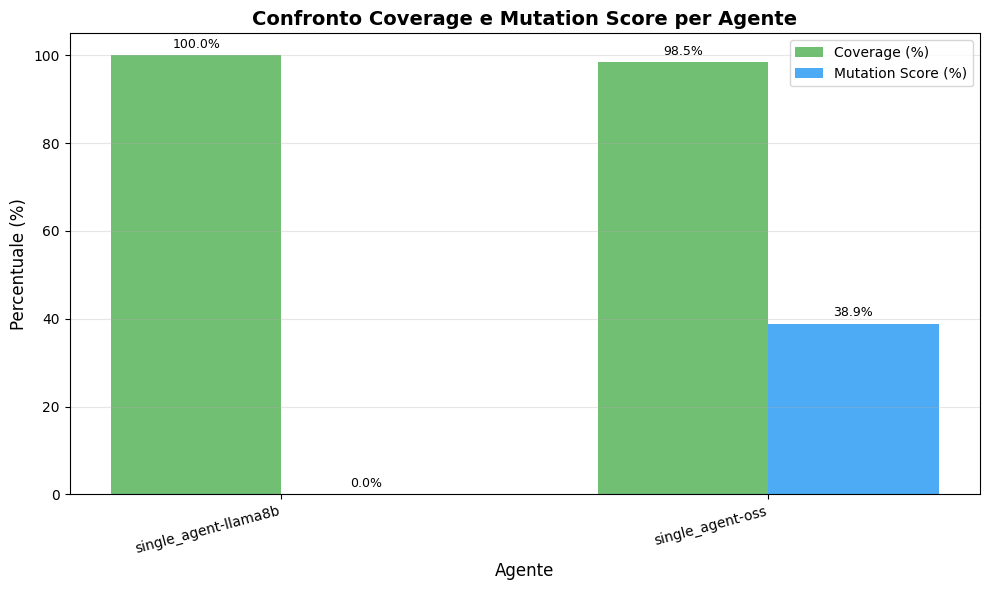

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepariamo dati per il grafico
plot_data = (
    df_results.groupby("agent")
    .agg({"coverage_percent": "mean", "mutation_score": "mean"})
    .reset_index()
)

# Creiamo il grafico a barre affiancate
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(plot_data))
width = 0.35

bars1 = ax.bar(
    [i - width / 2 for i in x],
    plot_data["coverage_percent"],
    width,
    label="Coverage (%)",
    color="#4CAF50",
    alpha=0.8,
)
bars2 = ax.bar(
    [i + width / 2 for i in x],
    plot_data["mutation_score"],
    width,
    label="Mutation Score (%)",
    color="#2196F3",
    alpha=0.8,
)

ax.set_xlabel("Agente", fontsize=12)
ax.set_ylabel("Percentuale (%)", fontsize=12)
ax.set_title(
    "Confronto Coverage e Mutation Score per Agente", fontsize=14, fontweight="bold"
)
ax.set_xticks(x)
ax.set_xticklabels(plot_data["agent"], rotation=15, ha="right")
ax.legend()
ax.set_ylim(0, 105)

# Aggiungi valori sulle barre
for bar in bars1:
    height = bar.get_height()
    ax.annotate(
        f"{height:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
    )

for bar in bars2:
    height = bar.get_height()
    ax.annotate(
        f"{height:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.grid(axis="y", alpha=0.3)
plt.show()

## Export Risultati

Salviamo i risultati in un file CSV per analisi successive.

In [ ]:
# Salva risultati dettagliati
output_path = PROJECT_ROOT / "data" / "metrics_results.csv"
df_results.to_csv(output_path, index=False)
print(f"Risultati salvati in: {output_path}")

# Salva summary
summary_path = PROJECT_ROOT / "data" / "metrics_summary.csv"
final_summary.to_csv(summary_path)
print(f"Summary salvato in: {summary_path}")

Risultati salvati in: /home/einrich99/Progetti/LLM-Agents-for-Collaborative-Test-Case/data/metrics_results.csv
Summary salvato in: /home/einrich99/Progetti/LLM-Agents-for-Collaborative-Test-Case/data/metrics_summary.csv
